In [9]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt 

# Read a pandas DataFrame
df = pd.read_csv("data/train_data.csv")

In [35]:
TurbList = []
for i in (sorted(pd.unique(df["TurbID"]))):
    tmp = df[df["TurbID"] == i]
    tmp.reset_index(inplace=True,drop=True)
    TurbList.append(tmp)

### 결측치 
- 터빈1 [9356:9585] 314개 == 2일 4시간 40분 연속치

In [105]:
data = TurbList[0].iloc[9585:]
data = data.fillna(method = 'bfill')
testdata = data

In [106]:
tmp_data = data.drop(["TurbID", "Day","Tmstamp"], axis = 1)
tmp_data = tmp_data.set_index(pd.date_range(start="2022-01-01", periods=len(data), freq="10T"),append=False)

In [107]:
tmp_data.head(5)

,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
2022-01-01 00:00:00,11.07,2.29,38.60,50.53,52.37,1.03,1.03,1.03,-0.19,1416.35
2022-01-01 00:10:00,11.39,-1.70,38.70,50.67,60.54,1.04,1.04,1.04,-0.23,1423.96
2022-01-01 00:20:00,11.77,1.11,38.76,50.62,57.03,1.04,1.04,1.04,-0.30,1451.06
2022-01-01 00:30:00,10.11,-0.98,38.95,50.67,53.47,1.02,1.02,1.02,-0.23,1256.14
2022-01-01 00:40:00,10.82,0.59,39.11,51.08,55.04,1.01,1.01,1.01,-0.18,1375.47


In [52]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(tmp_data, value_cols="Patv")

# Set aside the last 36 months as a validation series
train, val = series[:-288], series[-288:]

In [83]:
def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 201 - 6):
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

In [53]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing(seasonal_periods=144)
model.fit(train_x)
prediction = model.predict(len(val), num_samples=1000)

c:\Users\kdy\anaconda3\envs\inhaAI\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


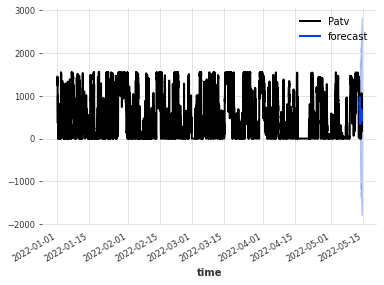

In [45]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

---

In [84]:
tmp_data

,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
time,,,,,,,,,,
2022-01-01 00:00:00,11.07,2.29,38.60,50.53,52.37,1.03,1.03,1.03,-0.19,1416.35
2022-01-01 00:10:00,11.39,-1.70,38.70,50.67,60.54,1.04,1.04,1.04,-0.23,1423.96
2022-01-01 00:20:00,11.77,1.11,38.76,50.62,57.03,1.04,1.04,1.04,-0.30,1451.06
2022-01-01 00:30:00,10.11,-0.98,38.95,50.67,53.47,1.02,1.02,1.02,-0.23,1256.14
2022-01-01 00:40:00,10.82,0.59,39.11,51.08,55.04,1.01,1.01,1.01,-0.18,1375.47
...,...,...,...,...,...,...,...,...,...,...
2022-05-14 09:40:00,4.70,-0.04,10.46,27.67,201.38,0.99,0.99,0.99,-0.29,296.34
2022-05-14 09:50:00,3.53,-2.37,11.32,28.65,191.85,0.99,0.99,0.99,-0.22,178.46
2022-05-14 10:00:00,3.50,-0.65,11.81,29.29,187.51,0.99,0.99,0.99,-0.24,164.19


In [85]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(tmp_data)

# Set aside the last 36 months as a validation series
train, val = series[:-288], series[-288:]

---

In [ ]:
from darts.models import VARIMA
#forecasting.varima
model = VARIMA()
model.fit(train)

In [79]:
prediction = model.predict(len(val), num_samples=1)

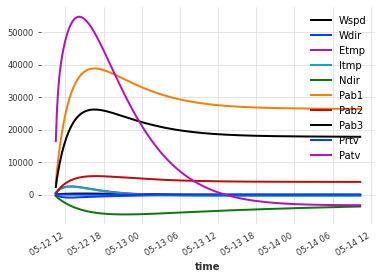

In [82]:
prediction.plot()

---

In [92]:
from darts.models import LightGBMModel
model_LGBM = LightGBMModel(lags=144)
model_LGBM.fit(train)

c:\Users\kdy\anaconda3\envs\inhaAI\lib\site-packages\darts\timeseries.py:4039: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(


In [ ]:
model_LGBM.backtest(train)

In [93]:
prediction = model_LGBM.predict(len(val))

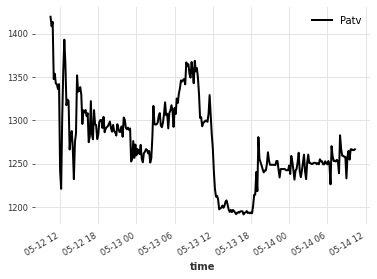

In [94]:
prediction["Patv"].plot()

In [95]:
t = prediction["Patv"].pd_dataframe()

In [97]:
a = t.reset_index(drop=True)

In [100]:
a.to_csv("t.csv")

---